In [32]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import make_moons
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [33]:
(xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.boston_housing.load_data()

In [34]:
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

xtrain = tf.cast(xtrain, dtype=tf.float32)
xtest = tf.cast(xtest, dtype=tf.float32)
ytrain = tf.cast(ytrain, dtype=tf.float32)
ytest = tf.cast(ytest, dtype=tf.float32)


In [35]:
def load_data(data, batch_size):
    data = tf.data.Dataset.from_tensor_slices(data)
    data = data.shuffle(buffer_size = 100)
    data = data.batch(batch_size)
    return data

def init_params(feature_dim):
    w = tf.Variable(tf.random.normal(shape = (feature_dim, 1), 
    mean=0, stddev=0.1), trainable = True)
    b = tf.Variable(tf.zeros(1), trainable = True)
    return w, b

def lin_reg(X, w, b):
    return tf.matmul(X, w) + b

def squared_loss(yhat, y):
    return (yhat - tf.reshape(y, yhat.shape))**2/2

def init_adagrad_states(feature_dim):
    s_w = tf.Variable(tf.zeros((feature_dim, 1)))
    s_b = tf.Variable(tf.zeros(1))
    return s_w, s_b

def sgd_adagrad(params, states, grads, learning_rate, batch_size):
    eps = 1e-6
    for param, state, grad in zip(params, states, grads):
        grad = grad/batch_size
        state[:].assign(state + grad**2)
        param[:].assign(param - learning_rate*grad/np.sqrt(state + eps)) 

In [36]:
lr = 0.03
num_epochs = 100
batch_size = 32

w, b = init_params(xtrain.shape[1])
training_loss = []
for epoch in range(num_epochs):
    for X, y in load_data((xtrain, ytrain), batch_size):
        X, y = tf.cast(X, dtype=tf.float32), tf.cast(y, dtype=tf.float32)
        with tf.GradientTape() as tape:
            # Do forward prop & Compute loss
            yhat = lin_reg(X, w, b)
            loss = squared_loss(yhat, y)

        # Compute Gradient
        dw, db = tape.gradient(loss, [w, b])

        # Update w, b with momentum
        s_w, s_b = init_adagrad_states(xtrain.shape[1])
        sgd_adagrad([w, b], [s_w, s_b], [dw, db], lr, batch_size)

    epoch_loss = np.round(tf.reduce_mean(squared_loss(lin_reg(xtrain, w, b), ytrain)), 2)
    training_loss.append(epoch_loss)
    if epoch % 10 == 0:
        print(f"epoch : {epoch}, training_loss : {epoch_loss}")

epoch : 0, training_loss : 272.7300109863281
epoch : 10, training_loss : 179.8300018310547
epoch : 20, training_loss : 113.79000091552734
epoch : 30, training_loss : 65.08000183105469
epoch : 40, training_loss : 32.220001220703125
epoch : 50, training_loss : 14.739999771118164
epoch : 60, training_loss : 11.390000343322754
epoch : 70, training_loss : 11.199999809265137
epoch : 80, training_loss : 11.270000457763672
epoch : 90, training_loss : 11.260000228881836


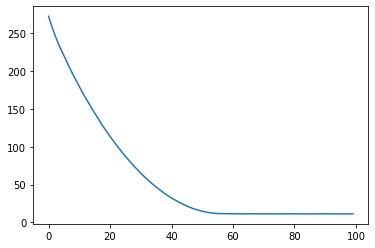

In [37]:
plt.plot(np.arange(num_epochs), training_loss)